In [1]:
import sys
sys.path.append("../")

In [2]:
from utils.common_train_utils import *
from utils.draw_candle_image import *
from utils.evaluate_old_models import *
from functools import partial
from model_code import *
from ta import add_all_ta_features
from ta.utils import dropna
import json
import keras
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pathlib
import shutil
import ta
import ta.momentum
import ta.trend
import tempfile
import tensorflow as tf
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots
import inspect

In [3]:
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

In [4]:
print(logdir)

C:\Users\ADMIN\AppData\Local\Temp\tmpqfued8di\tensorboard_logs


In [5]:
dataset_folder = "../dataset/btc_dataset_0_2_3_2014_2024_test_2023_2024_with_ema_macd_trend"
model_name = "model_5_biLSTM_ema_macd_trend"
model_parent_path = f"{dataset_folder}/model_save/{model_name}"
model_path = f"{model_parent_path}/{model_name}.keras"
config_and_loss_path = f"{model_parent_path}/config_and_loss.json"
continue_learning_dataset_name = "to_2024_11_25"
use_continue_learning = input(f"Use continue_learning_dataset {continue_learning_dataset_name}? (y/n) ").lower().strip()[0] == "y"


In [6]:
config = read_config(dataset_folder)
candle_type_and_directory_save: dict = config["candle_type_and_directory_save"]
previous_days = config["previous_days"]
next_days = config["next_days"]
days_result = config["days_result"]

In [7]:
dataset_test = load_dataset_of_each_type_and_combine(f"{dataset_folder}/test", candle_type_and_directory_save)
total_data_test = len(dataset_test)
dataset_continue_learning = load_dataset_of_each_type_and_combine(f"{dataset_folder}/continue_learning/{continue_learning_dataset_name}", candle_type_and_directory_save)
total_dataset_continue_learning = len(dataset_continue_learning)

if use_continue_learning:
    dataset_train = dataset_continue_learning
    model_name += f"_cl_{continue_learning_dataset_name}"
else:
    dataset_train = dataset_test
    model_name += f"_cl_test"

total_data_train = len(dataset_train)

In [8]:
model, function_transform_origin = load_model_and_transform_function(model_path, config_and_loss_path)
image_shape = get_image_shape(dataset_test, index_of_image=3)

In [9]:
batch_size = 64
STEPS_PER_EPOCH = total_data_train // batch_size + 1
name_sub_folder_save_metrics = f"{model_name}_{os.path.basename(dataset_folder)}"
name_folder_save_metrics = f"sizes/{model_name}_{os.path.basename(dataset_folder)}"
max_epochs = int(input(f"max_epochs = "))
metric_mae_name = "mae"
metric_mae_object = keras.metrics.MeanAbsoluteError(name=metric_mae_name)
metric_mse_name = "mse"
metric_mse_object = keras.metrics.MeanSquaredError(name=metric_mse_name)
val_loss_metric_mae_to_stop = float(input("val_loss_metric_mae_to_stop = "))
val_loss_metric_mse_to_stop = float(input("val_loss_metric_mse_to_stop = "))
start_learning_rate = float(input("start_learning_rate = ").lower().strip())
shuffle_buffer = 300
print(f"{STEPS_PER_EPOCH=}")
number_epochs_to_decrease_lr = int(input("number_epochs_to_decrease_lr = "))
number_epochs_to_wait = int(input("number_epochs_to_wait = "))

STEPS_PER_EPOCH=6


In [10]:
print(f"{STEPS_PER_EPOCH=}")
print(f"{val_loss_metric_mae_to_stop=}")
print(f"{val_loss_metric_mse_to_stop=}")
print(f"{number_epochs_to_decrease_lr=}")
print(f"{number_epochs_to_wait=}")

STEPS_PER_EPOCH=6
val_loss_metric_mae_to_stop=-1.0
val_loss_metric_mse_to_stop=-1.0
number_epochs_to_decrease_lr=10
number_epochs_to_wait=10


In [11]:
model_name

'model_5_biLSTM_ema_macd_trend_cl_test'

In [12]:
(total_data_train, total_data_test)

(364, 364)

In [13]:
train_ratio = 0.8  # 80% dữ liệu để train
train_size = int(train_ratio * len(dataset_train))

In [14]:
dataset_test = dataset_train.skip(train_size)
dataset_train = dataset_train.take(train_size)

In [15]:
(len(dataset_train), len(dataset_test))

(291, 73)

In [16]:
dataset_train_1 = dataset_train.shuffle(shuffle_buffer)
dataset_test_1 = dataset_test.shuffle(shuffle_buffer)

dataset_train_2 = dataset_train_1.batch(batch_size)
dataset_test_2 = dataset_test_1.batch(batch_size)

transform_function = partial(function_transform_origin, days_result)
dataset_train_3 = dataset_train_2.map(transform_function)
dataset_test_3 = dataset_test_2.map(transform_function)

In [17]:
# for features, labels in dataset_train_3.take(1):
#     print(features[0].shape)
#     print(features[1].shape)
#     print(labels.shape)

In [18]:
(len(dataset_train_3), len(dataset_test_3))

(5, 2)

In [19]:
class StopAtLossValue(keras.callbacks.Callback):
    def __init__(self, target_loss, metric_name):
        super(StopAtLossValue, self).__init__()
        self.target_loss = target_loss
        self.metric_name = metric_name

    def on_epoch_end(self, epoch, logs=None):
        # Lấy giá trị loss từ logs
        current_loss = logs.get(f"val_{self.metric_name}")
        if current_loss is not None and current_loss <= self.target_loss:
            print(f"\nĐạt target loss = {self.target_loss}, dừng training tại epoch {epoch + 1}")
            self.model.stop_training = True


class SaveModelCallback(keras.callbacks.Callback):
    def __init__(self, save_path):
        super().__init__()
        self.save_path = save_path

    def on_epoch_end(self, epoch, logs=None):
        # Tạo tên file với số epoch
        folder_tmp = f"{self.save_path}/tmp_model"
        file_name = f"{folder_tmp}/model_tmp_{epoch}.keras"
        self.model.save(file_name)  # Lưu toàn bộ model
        

class TrackingLossCallback(keras.callbacks.Callback):
    def __init__(self, metric_name):
        super().__init__()
        self.list_epochs = []
        self.list_loss = []
        self.metric_name = metric_name
        self.loss_key = f"val_{self.metric_name}"

    def on_epoch_end(self, epoch, logs=None):
        # Tạo tên file với số epoch
        self.list_epochs.append(epoch)
        self.list_loss.append(logs.get(self.loss_key))
    
    def get_df_result(self):
        df = pd.DataFrame({
            "epoch": self.list_epochs,
            self.loss_key: self.list_loss
        })
        df.sort_values(self.loss_key, inplace=True)
        return df

In [20]:
def get_optimizer(start_learning_rate, number_epochs_to_decrease_lr):
    lr_schedule = keras.optimizers.schedules.InverseTimeDecay(
        start_learning_rate,
        decay_steps=STEPS_PER_EPOCH*number_epochs_to_decrease_lr,
        decay_rate=1,
        staircase=False
    )
    
    return keras.optimizers.Adam(lr_schedule)

tracking_loss_callback = TrackingLossCallback(metric_mse_name)
def get_callbacks(name, metric_name, number_epochs_to_wait):
    return [
        tfdocs.modeling.EpochDots(),
        StopAtLossValue(val_loss_metric_mae_to_stop, metric_mae_name),
        StopAtLossValue(val_loss_metric_mse_to_stop, metric_mse_name),
        SaveModelCallback(dataset_folder),
        tracking_loss_callback,
        keras.callbacks.EarlyStopping(monitor=f'val_loss', patience=number_epochs_to_wait),
        keras.callbacks.TensorBoard(logdir/name)
    ]
  
  
model.compile(
    loss=keras.losses.MeanSquaredError(),
    optimizer=get_optimizer(start_learning_rate, number_epochs_to_decrease_lr),
    metrics=[
        metric_mae_object,
        metric_mse_object
    ],
)


In [21]:
# Ví dụ
all_models_folder_path = os.path.join(os.path.abspath(dataset_folder), "model_save")
evaluate_all_models_in_dataset_folder(
    all_models_folder_path, 
    dataset_test_2,
    days_result
)

d:\code\selenium\.venv\lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['ema_9_input', 'macd_history_input', 'trend_type_input', 'image_input']. Received: the structure of inputs=('*', '*', '*', '*')
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 4.1526 - mae: 1.3429 - mse: 4.1526
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 4.1116 - mae: 1.2627 - mse: 4.1116


,model_name,mse,mae
1,model_5_biLSTM_ema_macd_trend,4.127203,1.261478
0,model_5_bi2LSTM_ema_macd_trend,4.247036,1.355192


In [22]:
is_start_train = input("Start train? (y/n): ").lower()[0] == "y"
if is_start_train:
    folder_tmp = f"{dataset_folder}/tmp_model"
    os.makedirs(folder_tmp, exist_ok=False)
    history = model.fit(
        dataset_train_3, 
        validation_data=dataset_test_3,
        epochs=max_epochs, 
        steps_per_epoch=STEPS_PER_EPOCH,
        callbacks=get_callbacks(name_folder_save_metrics, metric_mse_name, number_epochs_to_wait)
    )

Epoch 1/100


d:\code\selenium\.venv\lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['ema_9_input', 'macd_history_input', 'trend_type_input', 'image_input']. Received: the structure of inputs=('*', '*', '*', '*')
  warnings.warn(


5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - loss: 4.4450 - mae: 1.3777 - mse: 4.4450

C:\Users\ADMIN\AppData\Local\Programs\Python\Python39\lib\contextlib.py:137: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch: 0, loss:4.1976,  mae:1.3266,  mse:4.1976,  val_loss:4.1498,  val_mae:1.2399,  val_mse:4.1498,  
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 472ms/step - loss: 4.4037 - mae: 1.3692 - mse: 4.4037 - val_loss: 4.1498 - val_mae: 1.2399 - val_mse: 4.1498
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 407ms/step - loss: 4.3313 - mae: 1.3495 - mse: 4.3313 - val_loss: 4.1351 - val_mae: 1.2395 - val_mse: 4.1351
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 389ms/step - loss: 4.1801 - mae: 1.3233 - mse: 4.1801 - val_loss: 4.1216 - val_mae: 1.2457 - val_mse: 4.1216
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 386ms/step - loss: 3.8890 - mae: 1.2609 - mse: 3.8890 - val_loss: 4.1180 - val_mae: 1.2467 - val_mse: 4.1180
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 393ms/step - loss: 3.7940 - mae: 1.2694 - mse: 3.7940 - val_loss: 4.1055 - val_mae: 1.2477 - val_mse: 4.1055
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 384ms/step - loss: 3.7084 - mae: 1.2429 - mse: 3.7084 - val_loss: 4.0981 - val_mae: 1.2493 - val_mse: 4.0981
Epoch 7/100
6/

In [23]:
loss = model.evaluate(dataset_test_3, verbose=2)

2/2 - 1s - 341ms/step - loss: 4.1190 - mae: 1.2658 - mse: 4.1190


In [24]:
loss

[4.1190266609191895, 1.26576566696167, 4.1190266609191895]

In [25]:
def get_folder_path_to_save_model(model_name):
    new_model_name = model_name
    path_save = f"{dataset_folder}/model_save/{new_model_name}"
    while os.path.exists(path_save):
        print(f"-- {path_save} already exists")
        new_model_name = new_model_name + "_1"
        path_save = f"{dataset_folder}/model_save/{new_model_name}"
        print(f"-- Change to {path_save}")
    os.makedirs(path_save, exist_ok=False)
    return path_save, new_model_name 

In [26]:
def save_model(model: keras.Sequential, folder_path, new_model_name):
    path_save = f"{folder_path}/{new_model_name}.keras"
    abspath_save = os.path.abspath(path_save)
    model.save(abspath_save)
    return path_save

In [27]:
def save_model_and_config(model: keras.Sequential):
    folder_path, new_model_name = get_folder_path_to_save_model(model_name)
    model_name_saved = save_model(model, folder_path, new_model_name)
    loss = model.evaluate(dataset_test_3)
    config_and_loss = {
        "config": {
            "batch_size": batch_size,
            "STEPS_PER_EPOCH": STEPS_PER_EPOCH,
            "name_sub_folder_save_metrics": name_sub_folder_save_metrics,
            "name_folder_save_metrics": name_folder_save_metrics,
            "max_epochs": max_epochs,
            "val_loss_metric_mae_to_stop": val_loss_metric_mae_to_stop,
            "val_loss_metric_mse_to_stop": val_loss_metric_mse_to_stop,
            "start_learning_rate": start_learning_rate,
            "shuffle_buffer": shuffle_buffer,
            "number_epochs_to_decrease_lr": number_epochs_to_decrease_lr,
            "number_epochs_to_wait": number_epochs_to_wait,
            "model_function": function_transform_origin.__name__,
        },
        "loss": {
            "val_mse_loss": loss[0],
            "val_mae_loss": loss[1],
        }
    }
    with open(f"{folder_path}/config_and_loss.json", "w") as file:
        json.dump(config_and_loss, file, indent=2)
    
    with open(f"{model_parent_path}/model_function_code.py", "r") as file_origin:
        code_str = file_origin.read()
        with open(f"{folder_path}/model_function_code.py", "w") as file_to_write:
            file_to_write.write(code_str)
    
    return new_model_name

In [28]:
list_name_models = []
list_models = []

In [29]:
tracking_loss_callback.get_df_result()

,epoch,val_mse
5,5,4.098096
12,12,4.105013
4,4,4.105473
6,6,4.105814
11,11,4.108033
7,7,4.111610
13,13,4.115969
3,3,4.117979
15,15,4.119026
14,14,4.119946


In [30]:
if input("save model? (y/n): ").lower()[0] == "y":
    is_save_model_from_tmp = input("Save model from tmp file? (y/n): ").lower()[0] == "y"
    
    if is_save_model_from_tmp:
        while True and os.path.exists(folder_tmp):
            epoch = input(f"Epoch = ")
            if not str.isdigit(epoch):
                break
            else:
                epoch = int(epoch)
            
            model_tmp_name = f"model_tmp_{epoch}.keras"
            print(f"Save {model_tmp_name}")
            model_tmp_path = f"{folder_tmp}/{model_tmp_name}"
            if not os.path.exists(model_tmp_path):
                print(f"model {model_tmp_path} does not exist.")
                continue
            
            try:
                model_tmp = keras.models.load_model(model_tmp_path)
                name_model_tmp_saved = save_model_and_config(model_tmp)
                list_name_models.append(name_model_tmp_saved)
                list_models.append(model_tmp)
            except Exception as err:
                print(err)
                continue
    
    is_save_last_model = input("Save last model? (y/n): ").lower()[0] == "y"
    if is_save_last_model:
        name_last_model_saved = save_model_and_config(model)
        list_name_models.append(name_last_model_saved)
        list_models.append(model)

is_delete_tmp_model_folder = input("Delete model tmp folder? (y/n): ").lower()[0] == "y"
if is_delete_tmp_model_folder:
    if os.path.exists(folder_tmp):
        shutil.rmtree(folder_tmp)
    else:
        print(f"{folder_tmp} does not exist.")
    

Save model_tmp_5.keras


d:\code\selenium\.venv\lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['ema_9_input', 'macd_history_input', 'trend_type_input', 'image_input']. Received: the structure of inputs=('*', '*', '*', '*')
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 4.1508 - mae: 1.2574 - mse: 4.1508
Save model_tmp_6.keras
-- ../dataset/btc_dataset_0_2_3_2014_2024_test_2023_2024_with_ema_macd_trend/model_save/model_5_biLSTM_ema_macd_trend_cl_test already exists
-- Change to ../dataset/btc_dataset_0_2_3_2014_2024_test_2023_2024_with_ema_macd_trend/model_save/model_5_biLSTM_ema_macd_trend_cl_test_1
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 4.0685 - mae: 1.2550 - mse: 4.0685 
Save model_tmp_12.keras
-- ../dataset/btc_dataset_0_2_3_2014_2024_test_2023_2024_with_ema_macd_trend/model_save/model_5_biLSTM_ema_macd_trend_cl_test already exists
-- Change to ../dataset/btc_dataset_0_2_3_2014_2024_test_2023_2024_with_ema_macd_trend/model_save/model_5_biLSTM_ema_macd_trend_cl_test_1
-- ../dataset/btc_dataset_0_2_3_2014_2024_test_2023_2024_with_ema_macd_trend/model_save/model_5_biLSTM_ema_macd_trend_cl_test_1 already exists
-- Change to ../dataset/btc_dataset_0_2_3_2014_2024_test_2023_2024_with_ema_macd_trend/mo

In [31]:
for model_loaded, model_name_loaded in zip(list_models, list_name_models):
    loss = model_loaded.evaluate(dataset_test_3)
    print(f"{model_name_loaded}: {loss}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 4.0064 - mae: 1.2439 - mse: 4.0064 
model_5_biLSTM_ema_macd_trend_cl_test: [4.0980963706970215, 1.249291181564331, 4.0980963706970215]
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 4.1786 - mae: 1.2577 - mse: 4.1786 
model_5_biLSTM_ema_macd_trend_cl_test_1: [4.105814456939697, 1.2494757175445557, 4.105813980102539]
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 4.2334 - mae: 1.2768 - mse: 4.2334 
model_5_biLSTM_ema_macd_trend_cl_test_1_1: [4.105013847351074, 1.2553720474243164, 4.105013370513916]
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 4.0996 - mae: 1.2571 - mse: 4.0996 
model_5_biLSTM_ema_macd_trend_cl_test_1_1_1: [4.115968704223633, 1.2602925300598145, 4.115968704223633]
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 4.1554 - mae: 1.2623 - mse: 4.1554 
model_5_biLSTM_ema_macd_trend_cl_test_1_1_1_1: [4.108033180236816, 1.2521189451217651, 4.108033657073975]


In [32]:
size_histories = {}

In [33]:
size_histories[name_sub_folder_save_metrics] = history 

(3.0, 5.0)

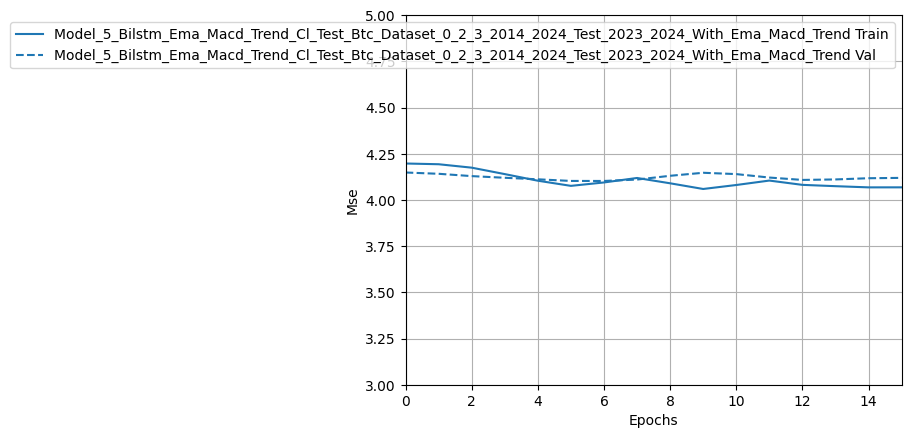

In [39]:
plotter = tfdocs.plots.HistoryPlotter(metric=metric_mse_name, smoothing_std=10)
plotter.plot(size_histories)
plt.ylim([3,5])

In [35]:
# train_dataset = tf.data.Dataset.load(f'{dataset_folder}/train/next_3_day_up')
# test_dataset = tf.data.Dataset.load(f'{dataset_folder}/test/next_3_day_up')
# for x_train, y_train, date_train in train_dataset.take(2):
#     pass
# for x_test, y_test, date_test in test_dataset.take(2):
#     pass
# plt.imshow(x_train)
# y_train
# plt.imshow(x_test)
# y_test

In [36]:
list_name_models

['model_5_biLSTM_ema_macd_trend_cl_test',
 'model_5_biLSTM_ema_macd_trend_cl_test_1',
 'model_5_biLSTM_ema_macd_trend_cl_test_1_1',
 'model_5_biLSTM_ema_macd_trend_cl_test_1_1_1',
 'model_5_biLSTM_ema_macd_trend_cl_test_1_1_1_1']

In [37]:
dataset_folder

'../dataset/btc_dataset_0_2_3_2014_2024_test_2023_2024_with_ema_macd_trend'